Just a reader-friendly version of isolate.ipynb

## Initial Cuts

In [14]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
path = '/Users/chrislam/Desktop/sculpting/berger_gaia_kepler/'
# all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable2_Final.txt > GKSPCPapTable2_cleaned.txt
table2 = pd.read_csv(path+'GKSPCPapTable2_cleaned.txt', sep='&', header=0)
print(len(table2))
print(table2.head())
print(table2.columns)

186301
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757099     0.873          0.054         -0.039    5364.9          102.7   
2  757137     1.669          0.309         -0.300    4628.7           84.8   
3  757280     1.715          0.086         -0.089    6856.8          144.4   
4  757450     0.914          0.062         -0.057    5301.2          111.0   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  iso_age  \
0          -86.6     3.373          0.067         -0.081  ...     2.47   
1          -84.9     4.318          0.037         -0.029  ...    15.20   
2          -76.2     2.388          0.083         -0.086  ...     1.51   
3         -139.9     3.834          0.033         -0.032  ...     1.24   
4         -103.1     4.432          0.045         -0.044  ...     9.46   

   unReAgeFlag  iso_age_err1  iso_age_err2  iso_dis  iso_dis_err1  \
0         

In [15]:
# remove stars with unreliable ages or bad goodness of fit
table2 = table2.loc[(table2.unReAgeFlag.isnull()) & (table2.iso_gof==1.)]
print(len(table2))

150560


In [16]:
# remove stars with uninformative posteriors (per paper, terminal age of main sequence > 20 Gyr)
table2 = table2.loc[table2['TAMS']<=20]
print(len(table2))
# nice to see that tracks with bad gof or unreliable age

150560


In [17]:
# remove stars beyond [3700, 7500] K Teff, ie. keep only FGK stars
fgk = table2.loc[(table2['iso_teff'] <= 7500) & (table2['iso_teff'] >= 3700)]
print(len(fgk))

147900


In [18]:
# introduce Table 1 to use RUWE (re-normalized unit-weight error), aka binary star/edge-of-parameter space classifier
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable1_Final.txt > GKSPCPapTable1_cleaned.txt
table1 = pd.read_csv(path+'GKSPCPapTable1_cleaned.txt', sep='&', header=0)
table1 = table1.loc[table1.RUWE<=1.2]
print(len(table1))
print(table1.head())
print(table1.columns)

164740
      KIC     gmag  gmag_err    kmag  kmag_err  parallax  parallax_err    feh  \
0  757076  12.3510    0.0203   9.559     0.017    1.5239        0.0483    NaN   
2  757137  10.0523    0.0279   6.722     0.017    1.7534        0.0253    NaN   
3  757280  12.1329    0.0200  10.627     0.018    1.2137        0.0220    NaN   
4  757450  15.8950    0.0202  13.118     0.029    1.1989        0.0261  0.229   
7  892010  12.6168    0.0209   9.041     0.017    0.5414        0.0242    NaN   

   feh_err    RUWE  num_gaia_companions Kmag_final_prov evstate  
0      NaN  0.9467                    0             NaN     NaN  
2      NaN  0.9126                    0             NaN     RGB  
3      NaN  0.8704                    0             NaN     NaN  
4     0.15  1.0300                    0             NaN     NaN  
7      NaN  1.0141                    0             NaN     NaN  
Index(['KIC', 'gmag', 'gmag_err', 'kmag', 'kmag_err', 'parallax',
       'parallax_err', 'feh', 'feh_err', 'RU

In [19]:
# join tables
catalog = pd.merge(fgk, table1, how='inner', on='KIC')
print(catalog.head())
print(len(catalog))

      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757137     1.669          0.309         -0.300    4628.7           84.8   
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
4  892010     1.710          0.708         -0.402    4555.8          141.3   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...    kmag  \
0          -86.6     3.373          0.067         -0.081  ...   9.559   
1          -76.2     2.388          0.083         -0.086  ...   6.722   
2         -139.9     3.834          0.033         -0.032  ...  10.627   
3         -103.1     4.432          0.045         -0.044  ...  13.118   
4          -92.4     2.299          0.163         -0.119  ...   9.041   

   kmag_err  parallax  parallax_err    feh  feh_err    RUWE  \
0     0.017    1.5239        

In [20]:
# isolate giant stars
# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
catalog['logR'] = np.log10(catalog.iso_rad)
catalog['is_giant'] = np.where(catalog['logR'] >= 0.00035*(catalog['iso_teff'] - 4500) + 0.15, True, False)
catalog = catalog.loc[catalog['is_giant'] == False]
print(len(catalog))
print(catalog.head())

112397
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
6  892195     0.862          0.057         -0.040    5333.4          101.3   
7  892667     1.548          0.081         -0.087    6704.9          148.8   
8  892675     1.038          0.066         -0.076    5929.4          108.9   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  parallax  \
2         -139.9     3.834          0.033         -0.032  ...    1.2137   
3         -103.1     4.432          0.045         -0.044  ...    1.1989   
6          -84.2     4.372          0.039         -0.029  ...    2.0802   
7         -128.8     3.950          0.034         -0.036  ...    0.8512   
8         -108.1     4.385          0.035         -0.043  ...    1.7114   

   parallax_err    feh  feh_err    RUWE  num_gaia_companions  Kmag_final_

In [21]:
# remove stars older than the age of the Universe
catalog = catalog.loc[catalog.iso_age <= 14.]

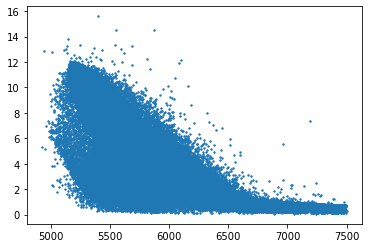

In [22]:
plt.scatter(catalog.iso_teff, np.abs(catalog.iso_age_err1)+np.abs(catalog.iso_age_err2), s=2)
plt.show()

#### Big decision here

Do I make my age error cuts based on the same value for all stars (1 Gyr) or based on fractional age errors like Berger et al 2020a do (median is at 0.56)?

109508


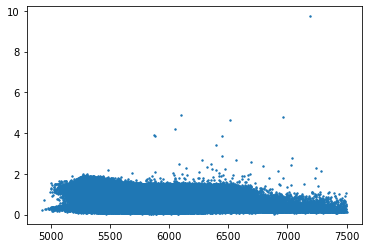

64491
1778
0.027569738413111906


In [23]:
### OLD WAY
# get rid of stars with age errors greater than 1 Gyr
print(len(catalog))
#catalog = catalog.loc[np.abs(catalog.iso_age_err1) < 1.]
#catalog = catalog.loc[np.abs(catalog.iso_age_err2) < 1.]

### POTENTIAL NEW WAY
# get rid of stars with fractional age errors greater than 0.75 (after the last peak, based on Fig 11 in Berger et al 2020a
catalog['fractional_err1'] = catalog.iso_age_err1/catalog.iso_age
catalog['fractional_err2'] = catalog.iso_age_err2/catalog.iso_age
plt.scatter(catalog.iso_teff, catalog.fractional_err1, s=2)
plt.show()

catalog = catalog.loc[catalog.fractional_err1 <= 0.56]
catalog = catalog.loc[np.abs(catalog.fractional_err2) <= 0.56]
print(len(catalog))
print(len(catalog.loc[catalog.iso_teff < 5300])) # how many of these are K dwarfs?
print(len(catalog.loc[catalog.iso_teff < 5300])/len(catalog))

In [13]:
# young vs old fraction
print(len(catalog.loc[catalog.iso_age <= 1]))
print(len(catalog.loc[catalog.iso_age > 1]))
print(len(catalog.loc[catalog.iso_age <= 1])/len(catalog.loc[catalog.iso_age > 1]))

735
66645
0.011028584289894216


In [11]:
catalog.to_csv('/Users/chrislam/Desktop/sculpting/berger_kepler_stellar_fgk.csv', index=False)

I *guess* there are enough K dwarfs left to warrant including them in the title of this project.

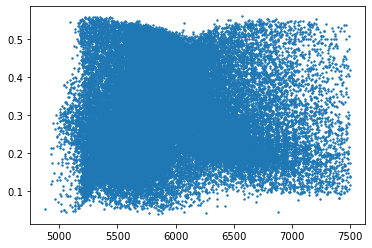

In [13]:
#plt.scatter(catalog.iso_teff, np.abs(catalog.iso_age_err1)+np.abs(catalog.iso_age_err2), s=2)
plt.scatter(catalog.iso_teff, (np.abs(catalog.fractional_err1)+np.abs(catalog.fractional_err2))/2, s=2)
plt.show()

[   4   27   81  121  220  467  634  763  885 1150 1621 1984 2354 2806
 3231 3591 3911 3832 3832 3588 3287 3022 2649 2415 2154 1844 1708 1667
 1396 1204 1064  930  848  753  600  575  519  463  311  345  320  204
  229  165  185  132  127  109   89   75] [4923.6   4975.122 5026.644 5078.166 5129.688 5181.21  5232.732 5284.254
 5335.776 5387.298 5438.82  5490.342 5541.864 5593.386 5644.908 5696.43
 5747.952 5799.474 5850.996 5902.518 5954.04  6005.562 6057.084 6108.606
 6160.128 6211.65  6263.172 6314.694 6366.216 6417.738 6469.26  6520.782
 6572.304 6623.826 6675.348 6726.87  6778.392 6829.914 6881.436 6932.958
 6984.48  7036.002 7087.524 7139.046 7190.568 7242.09  7293.612 7345.134
 7396.656 7448.178 7499.7  ]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


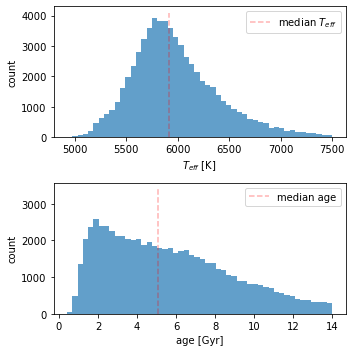

In [24]:
# teff histogram for all stars with well-constrained ages 
teff_hist, teff_bin_edges = np.histogram(catalog.iso_teff, bins=50)
print(teff_hist, teff_bin_edges)
#plt.bar(teff_bin_edges[:-1], teff_hist, width = 0.3)

fig, axes = plt.subplots(figsize=(5,5))
ax1 = plt.subplot2grid((2,1), (0,0))
ax1.hist(catalog.iso_teff, bins=50, alpha=0.7)
ax1.set_ylabel("count")
ax1.set_xlabel(r"$T_{eff}$ [K]")
# plot vertical red line through median Teff
ax1.plot([np.median(catalog.iso_teff), np.median(catalog.iso_teff)], 
         [0,4100], color='r', alpha=0.3, linestyle='--', label=r'median $T_{eff}$')
ax1.legend()

ax2 = plt.subplot2grid((2,1), (1,0))
ax2.hist(catalog.iso_age, bins=50, alpha=0.7)
# plot vertical red line through median age 
ax2.plot([np.median(catalog.iso_age), np.median(catalog.iso_age)], 
         [0,3400], color='r', alpha=0.3, linestyle='--', label='median age')
ax2.set_ylabel("count")
ax2.set_xlabel("age [Gyr]")
ax2.legend()
fig.tight_layout()
plt.savefig('/Users/chrislam/Desktop/sculpting/paper/sample_properties.eps', format='eps')
plt.show()

#plt.hist(catalog.iso_mass, bins=50)
#plt.show()

In [25]:
len(catalog)

64491

### Cross matching with Kepler (Bedell's gaia-kepler.fun)

In [ ]:
# cross-matching from Megan Bedell's gaia-kepler.fun KIC objs
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
hdu1 = fits.open(path+'kepler_dr2_1arcsec.fits')
data = hdu1[1].data
header = hdu1[1].header
columns = hdu1[1].columns
hdu1.close()

In [ ]:
print(len(data[0]))
print(data[0])
print(len(columns))
print(columns)

In [15]:
# let's read into pandas table instead
###kep_data = Table.read(path+'kepler_dr2_1arcsec.fits', format='fits')
###kep_data = kep_data.to_pandas() --> TypeError: data type '>I2' not understood
### decode byte literal column to string
###kep_data['planet?'] = kep_data['planet?'].str.decode("utf-8")

with fits.open(path+'kepler_dr2_1arcsec.fits') as kep_data:
    kep_data = pd.DataFrame(kep_data[1].data)
    
kep_data_thin = kep_data[['kepid','planet?']]
print(kep_data_thin.head())

    kepid planet?
0  757076    none
1  757099    none
2  757137    none
3  757280    none
4  757450    conf


In [16]:
# join Bedell cross-match with Berger catalog
crossmatch = pd.merge(catalog, kep_data, how='inner', left_on='KIC', right_on='kepid')
print(len(catalog))
print(len(kep_data))
print(len(crossmatch))
print(crossmatch.head())

19969
201312
19995
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757280     1.715          0.086         -0.089    6856.8          144.4   
1  892667     1.548          0.081         -0.087    6704.9          148.8   
2  892678     1.584          0.071         -0.062    5890.4          121.6   
3  892713     1.731          0.219         -0.087    6238.9          123.4   
4  892828     1.398          0.071         -0.069    6464.3          137.7   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  mass_err2  \
0         -139.9     3.834          0.033         -0.032  ...     -0.157   
1         -128.8     3.950          0.034         -0.036  ...     -0.236   
2         -114.9     3.574          0.030         -0.030  ...     -0.204   
3         -129.8     3.548          0.066         -0.037  ...     -0.270   
4         -128.9     4.034          0.032         -0.034  ...     -0.217   

   prov_sec  nconfp  nkoi  ntce    jmag    hmag  kmag_y

In [ ]:
list(crossmatch.columns)

In [79]:
# could we get planet multiplicity from KIC duplicates?
print(len(crossmatch))
crossmatch['dupe_label'] = crossmatch.duplicated(subset=['kepid'], keep=False)
print(crossmatch.loc[crossmatch.dupe_label == True])
print(list(crossmatch.loc[crossmatch.dupe_label == True].kepid))
# no.

19995
            KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  ...  \
77      1573954     1.484          0.096         -0.087    6932.7  ...   
78      1573954     1.484          0.096         -0.087    6932.7  ...   
941     3129842     1.224          0.070         -0.077    6871.4  ...   
942     3129842     1.224          0.070         -0.077    6871.4  ...   
2014    3866583     1.684          0.095         -0.120    6476.7  ...   
...         ...       ...            ...            ...       ...  ...   
17612  10879850     1.447          0.063         -0.121    6182.3  ...   
18669  11506988     1.487          0.061         -0.145    6559.3  ...   
18670  11506988     1.487          0.061         -0.145    6559.3  ...   
18826  11607521     1.826          0.199         -0.193    6619.2  ...   
18827  11607521     1.826          0.199         -0.193    6619.2  ...   

         hmag  kmag_y  planet?  kepler_gaia_ang_dist  dupe_label  
77     13.442  13.470     none        

Chose 1" search radius Kepler data upon consultation with Megan Bedell. Also, see full isolate.ipynb under noodling/ directory where I replicate with 20" search radius data, as well as K2 data.

In [17]:
# use 1" search radius Kepler data

# drop duplicates on KIC, which we can do because we guaranteed one-to-one matching of KIC and planet-occurrence status
group_crossmatch = crossmatch.drop_duplicates(['KIC'])
print(len(crossmatch))
print(len(group_crossmatch))

# count Kepler objects with each type of planet occurrence
none = group_crossmatch.loc[group_crossmatch['planet?'] == 'none']
cand = group_crossmatch.loc[group_crossmatch['planet?'] == 'cand']
conf = group_crossmatch.loc[group_crossmatch['planet?'] == 'conf']
print(len(none))
print(len(cand))
print(len(conf))

# cand and conf planet occurrence rates across FGK dwarfs from Berger et al 2020
print("candidates only: ", len(cand)/len(group_crossmatch))
print("confirmed only: ", len(conf)/len(group_crossmatch))
print("candidates and confirmed: ", (len(cand)+len(conf))/len(group_crossmatch))

19995
19939
18959
864
116
candidates only:  0.04333216309744722
confirmed only:  0.005817744119564672
candidates and confirmed:  0.04914990721701189


In [81]:
# let's keep both confirmed and candidate planets
pos = crossmatch.loc[crossmatch['planet?'] != 'none']
print(len(pos))
pos['dupe_label'] = pos.duplicated(subset=['kepid'], keep=False)
print(pos.loc[pos.dupe_label == True])


983
            KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  ...  \
10883   8046659     1.189          0.066         -0.081    6847.6  ...   
10884   8046659     1.189          0.066         -0.081    6847.6  ...   
13760   9116510     1.152          0.049         -0.042    6691.2  ...   
13761   9116510     1.152          0.049         -0.042    6691.2  ...   
16251  10155080     1.250          0.070         -0.068    5843.9  ...   
16252  10155080     1.250          0.070         -0.068    5843.9  ...   

         hmag  kmag_y  planet?  kepler_gaia_ang_dist  dupe_label  
10883  13.491  13.523     cand              0.715064        True  
10884  13.491  13.523     cand              0.897246        True  
13760  12.772  12.716     cand              0.679795        True  
13761  12.772  12.716     cand              0.781874        True  
16251  11.651  11.627     cand              0.543404        True  
16252  11.651  11.627     cand              0.605712        True  

[6 rows

I also do this with all well-defined stars (ie. beyond just FGK) from Berger et al in the full isolate.ipynb notebook. But we'll move forward with only FGK stars here.

### Joining Kepler cross-match with Exoplanets archive dataset

I skipped past the Cross Matching with Kepler using Bedell's cross-match section.

In [16]:
# source: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative
path = '/Users/chrislam/Desktop/sculpting/crossmatch_fun/'
kois = pd.read_csv(path+'cumulative_2021.03.04_20.04.43.csv')
kois = kois.loc[kois.koi_disposition != 'FALSE POSITIVE']
print(kois)
print(list(kois.columns))

         kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0     10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1     10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2     10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
4     10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   
5     10872983  K00756.01  Kepler-228 d       CONFIRMED        CANDIDATE   
...        ...        ...           ...             ...              ...   
9538   9938836  K07978.01           NaN       CANDIDATE        CANDIDATE   
9542  10011213  K07982.01           NaN       CANDIDATE        CANDIDATE   
9552  10028127  K08193.01           NaN       CANDIDATE        CANDIDATE   
9560  10128825  K07986.01           NaN       CANDIDATE        CANDIDATE   
9562  10155286  K07988.01           NaN       CANDIDATE        CANDIDATE   

      koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  \
0       

In [17]:
positives_kepler = pd.merge(kois, catalog, how='inner', left_on='kepid', right_on='KIC') 
print(len(kois))
print(len(positives_kepler))
print(positives_kepler.head())
print(positives_kepler.columns)

4724
1300
      kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
1  10666592  K00002.01    Kepler-2 b       CONFIRMED        CANDIDATE   
2   6922244  K00010.01    Kepler-8 b       CONFIRMED        CANDIDATE   
3  11304958  K00764.01  Kepler-667 b       CONFIRMED        CANDIDATE   
4  11403044  K00766.01  Kepler-669 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      0.000              0              0              0              0  ...   
1      1.000              0              1              0              0  ...   
2      0.998              0              0              0              0  ...   
3      0.998              0              0              0              0  ...   
4      1.000              0              0              0              0  ...   

     feh  feh_err    RUWE  num_gaia_companions  Kmag_final_prov 

Honestly, I could've probably just skipped Berger+Bedell and gone straight from Berger+ExoplanetsArchive. See isolate_with_kois.ipynb for my start at transferring before deciding to fall for sunk cost "fallacy" (nothing wrong actually, just extra work). Oh well.

In [18]:
# check that pl_pnums > 1 come from the same star
print(positives_kepler[['iso_mass', 'iso_teff', 'iso_rad',
                        'iso_age', 'koi_count']].head(n=20))
# 'st_metfe', 'gmag', 'st_optmag', 'kmag',
print(len(positives_kepler.kepid.unique()))

    iso_mass  iso_teff  iso_rad  iso_age  koi_count
0      0.961    5639.8    1.233    10.35          1
1      1.515    6436.5    1.995     1.74          1
2      1.264    6365.3    1.545     2.62          1
3      1.093    5223.0    2.194     6.90          1
4      1.097    5969.1    1.309     4.97          1
5      1.039    5887.9    1.184     5.64          1
6      1.121    5225.3    2.268     6.21          1
7      1.088    5779.7    1.613     7.06          1
8      1.085    5536.7    1.897     7.37          1
9      1.087    5621.9    1.827     7.29          1
10     0.973    5648.4    1.357    10.41          1
11     0.936    5610.7    1.034     8.44          1
12     0.862    5328.5    0.963    13.09          1
13     0.924    5567.4    1.084    10.55          3
14     0.924    5567.4    1.084    10.55          3
15     0.924    5567.4    1.084    10.55          3
16     1.245    5971.2    1.437     3.23          4
17     1.245    5971.2    1.437     3.23          4
18     1.245

In [ ]:
# check that pl_pnums > 1 come from the same star
#print(positives_kepler[['iso_mass', 'mass', 'iso_teff', 'teff', 'iso_rad',
#                        'radius', 'iso_age', 'koi_count', 'planet?']].head(n=20))
# 'st_metfe', 'gmag', 'st_optmag', 'kmag',
#print(len(positives_kepler.kepid.unique()))

### CDPP

Characterize the noise between young and old stars with multiple CDPPs. Data from http://archive.stsci.edu/pub/kepler/catalogs/

### Final crossmatches and output

In [25]:
path = '/Users/chrislam/Desktop/sculpting/crossmatch_fun/'
kepler_stellar = pd.read_csv(path+'kepler_stellar_17.csv')
print(len(kepler_stellar))
print(kepler_stellar.head())

200038
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757076  2MASS J19240929+3635532  5160      171.0     -156.0  3.580   
1  757099  2MASS J19241033+3635377  5519      182.0     -149.0  3.822   
2  757137  2MASS J19241341+3633358  4706       74.0     -102.0  2.374   
3  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
4  757450  2MASS J19243302+3634385  5332      106.0      -96.0  4.500   

   logg_err1  logg_err2   feh  feh_err1  ...  timeout06p0  timeout07p5  \
0      0.928     -0.232 -0.10      0.30  ...          0.0          0.0   
1      0.638     -0.213 -0.22      0.35  ...          1.0          1.0   
2      0.030     -0.027 -0.10      0.20  ...          1.0          1.0   
3      0.258     -0.172 -0.24      0.25  ...          0.0          0.0   
4      0.050     -0.036 -0.08      0.15  ...          0.0          0.0   

   timeout09p0  timeout10p5  timeout12p0  timeout12p5  timeout15p0  \
0          0.0          0.0          0.

In [26]:
kepler_stellar_enriched = pd.merge(kepler_stellar, catalog, how='inner', left_on='kepid', right_on='KIC')
print(len(kepler_stellar_enriched))


67380


In [27]:
kepler_planet_enriched = pd.merge(kepler_stellar, positives_kepler, how='inner', left_on='kepid', right_on='kepid')
print(len(kepler_planet_enriched))

1300


In [28]:
# output enriched Berger cross-matches
kepler_stellar_enriched.to_csv('/Users/chrislam/Desktop/sculpting/berger_kepler_stellar_fgk.csv', index=False)
# output planet multiplicity
kepler_planet_enriched.to_csv('/Users/chrislam/Desktop/sculpting/pnum_plus_cands_fgk.csv', index=False)

Compute k

In [151]:
print(kepler_stellar_enriched.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count())
print(len(catalog)-833-134-38-15-5)

           kepid
koi_count       
1            833
2            134
3             38
4             15
5              5
66355


### Wait, why was there 900 planets before joining with NASA Exoplanets Archive? 

In [121]:
ds1 = set(kepler_stellar_enriched.kepid)
ds2 = set(crossmatch.loc[crossmatch['planet?'] != 'none'].kepid)
print(len(ds1))
print(len(ds2))
print(ds2.difference(ds1))

316
980
{5308419, 6103049, 8904714, 6463499, 11188249, 6129694, 9115681, 10004515, 5021732, 7919653, 6117415, 6774826, 10268714, 6965293, 7598128, 4464689, 9533489, 6707260, 8243263, 5122112, 8263752, 9850957, 6846544, 3766353, 4374610, 1572948, 11673686, 9101400, 9240664, 3336283, 9973855, 10877024, 1724513, 7700578, 8046689, 9048161, 9777256, 10356840, 10936427, 5273713, 4544628, 6781047, 9965691, 11819135, 10033279, 9711751, 5218441, 5982353, 5779606, 6766748, 7198881, 7989422, 6148271, 9474222, 9474232, 5443775, 9945280, 7841986, 10518725, 11763910, 3248332, 11466960, 6629588, 3240159, 6066403, 5185765, 9289960, 9205993, 4073707, 6066416, 8042747, 5271803, 8440062, 3342592, 6387969, 4073730, 10275074, 5480736, 2859299, 7362852, 9957668, 10352938, 10385708, 7377200, 10031409, 2162994, 2576692, 9906489, 6543674, 8773948, 9300285, 10338624, 6543683, 11569475, 5949765, 8380743, 4165960, 8524110, 6523216, 8690001, 8042835, 9959765, 8016214, 4649305, 6947164, 11774303, 5306720, 7770471, 

Plugged a few of these into MAST and they were all false positives. Then did the same for the kepler_stellar_enriched kepids and they were all planets. Looks like the Bedell cross-match was just out of date?